In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

##  자율주행 보조장치 (1) KITTI 데이터셋

In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

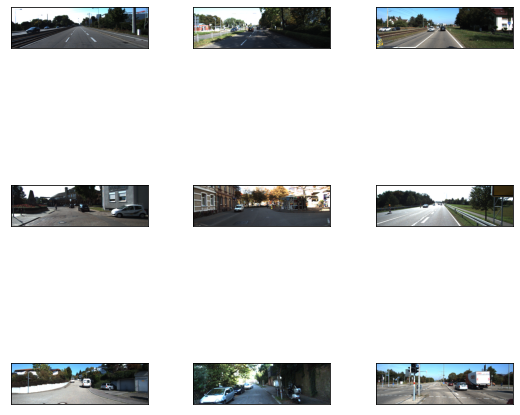

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

## 자율주행 보조장치 (2) 데이터 직접 확인하기

In [6]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-2.09,  2.29,  0.94,  1.52, -1.55,  1.63, -1.94], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.2717647 , 0.23938611, 0.5828075 , 0.275832  ],
       [0.36      , 0.4861228 , 0.53540105, 0.5139257 ],
       [0.3484492 , 0.39833602, 0.548369  , 0.41815832],
       [0.38946524, 0.4470517 , 0.5536631 , 0.4629079 ],
       [0.41877005, 0.5048708 , 0.5601604 , 0.51964456],
       [0.44820857, 0.49285138, 0.55326205, 0.5026252 ],
       [0.0026738 , 0.61211634, 1.        , 0.98588854]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.88, 0.69, 0.47],
       [1.51, 1.01, 0.97],
       [1.66, 0.65, 0.72],
       [1.72, 0.88, 0.9 ],
       [1.77, 0.94, 0.93],
       [1.73, 0.67, 0.83],
       [2.56, 2.06, 5.87]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array

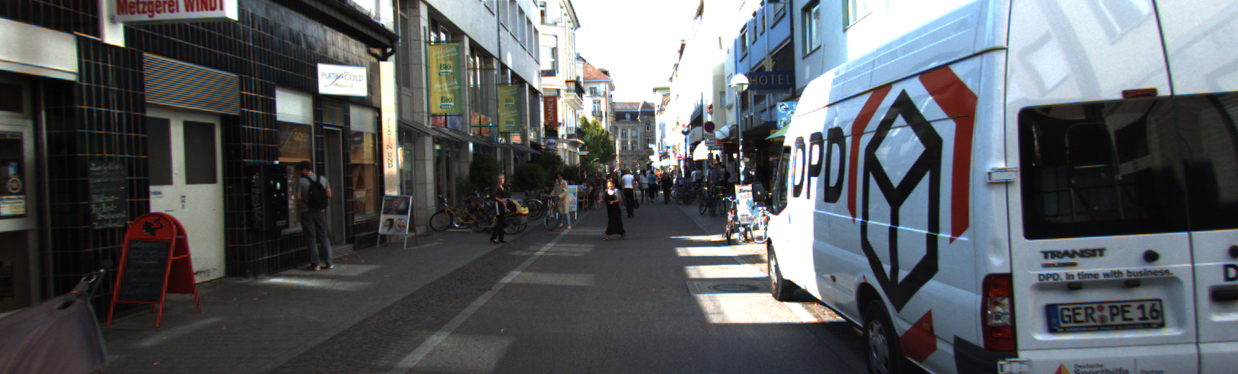

In [7]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

### BoundBox  설정

1238 374
(7, 4)
[[ 296.36002  272.36     341.48     156.03   ]
 [ 601.82     239.36     636.24     173.76001]
 [ 493.13998  243.68     517.68     168.91   ]
 [ 553.45     228.34     573.08     166.93001]
 [ 625.03     217.38     643.31995  164.50002]
 [ 610.15     206.37     622.25006  167.07999]
 [ 757.80005  373.      1220.53       0.     ]]
[296.36002 272.36    341.48    156.03   ]
[601.82    239.36    636.24    173.76001]
[493.13998 243.68    517.68    168.91   ]
[553.45    228.34    573.08    166.93001]
[625.03    217.38    643.31995 164.50002]
[610.15    206.37    622.25006 167.07999]
[ 757.80005  373.      1220.53       0.     ]
<PIL.Image.Image image mode=RGB size=1238x374 at 0x7F662075C310>


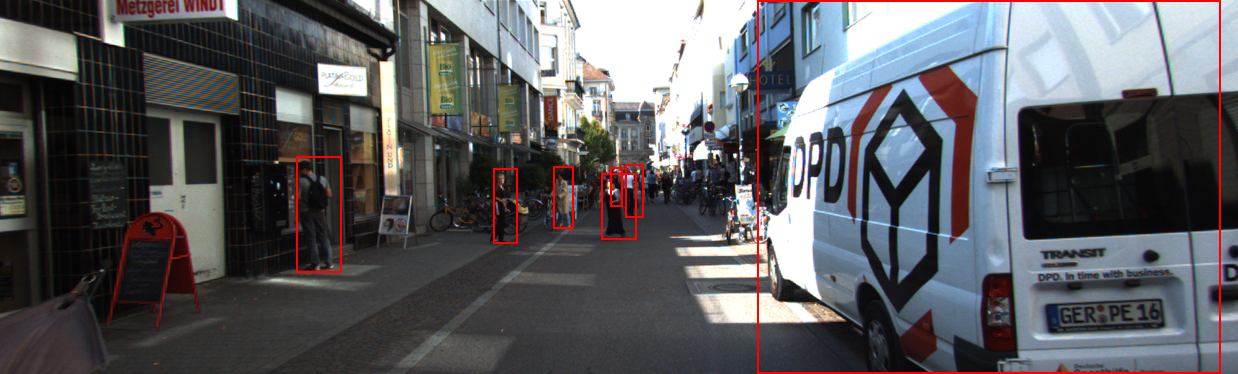

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

       # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

        # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image
visualize_bbox(img, objects['bbox'].numpy())

## keras-retinanet 실습 (1) 데이터 포맷 변경

### 클래스 및 바운딩 박스 정보 추출

In [9]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break

    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [10:46<00:00,  9.82it/s]


In [10]:

test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:14<00:00,  9.55it/s]


### 아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 주세요.

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## keras-retinanet 훈련 실습 (2) 셋팅

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 20 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2020-11-01 02:53:18.943466: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.
2020-11-01 02:53:20.887720: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-01 02:53:20.910125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-01 02:53:20.910432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-01 02:53:20.910453: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-01 02:53:20.912339: I tensorflo

Epoch 1/20
2020-11-01 02:53:28.847166: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-11-01 02:53:29.909171: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2020-11-01 02:53:29.951675: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2020-11-01 02:53:30.274493: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-11-01 02:53:38.167013: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020

195/195 [==============================] - ETA: 0s - loss: 1.6292 - regression_loss: 1.2831 - classification_loss: 0.3461
Epoch 00009: saving model to ./snapshots/resnet50_csv_09.h5
195/195 [==============================] - 61s 314ms/step - loss: 1.6292 - regression_loss: 1.2831 - classification_loss: 0.3461
Epoch 10/20
195/195 [==============================] - ETA: 0s - loss: 1.6869 - regression_loss: 1.3222 - classification_loss: 0.3647
Epoch 00010: saving model to ./snapshots/resnet50_csv_10.h5
195/195 [==============================] - 58s 299ms/step - loss: 1.6869 - regression_loss: 1.3222 - classification_loss: 0.3647
Epoch 11/20
195/195 [==============================] - ETA: 0s - loss: 1.5804 - regression_loss: 1.2411 - classification_loss: 0.3394
Epoch 00011: saving model to ./snapshots/resnet50_csv_11.h5
195/195 [==============================] - 58s 299ms/step - loss: 1.5804 - regression_loss: 1.2411 - classification_loss: 0.3394
Epoch 12/20
195/195 [======================

### 아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합시다.

In [13]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-11-01 03:14:47.514775: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-01 03:14:49.519595: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-01 03:14:49.554611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-01 03:14:49.556186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-01 03:14:49.556275: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-01 03:14:49.563966: I tensorflow/stream_executor/platform

## keras-retinanet 실습 (3) 시각화

변환한 모델을 load하고 추론 및 시각화를 해보세요!

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성해 주세요. 일정 점수 이하는 경우를 제거해야 함을 유의해 주세요.

아래에서 몇 가지 테스트 셋을 받아 사용해 보세요.


$ mkdir -p ~/aiffel/object_detection/test_set
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
$ mv test_set.zip ~/aiffel/object_detection/test_set
$ cd ~/aiffel/object_detection/test_set && unzip test_set.zip

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Using TensorFlow backend.


Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[592.40045 175.88464 626.2823  206.27983]
[196.90028 132.8914  356.15756 226.35294]


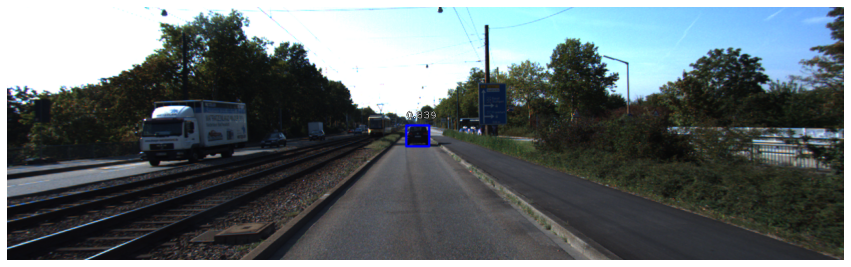

In [19]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[768.4981  145.03459 848.07166 324.66406]
[769.49896 149.03122 846.8771  314.76736]


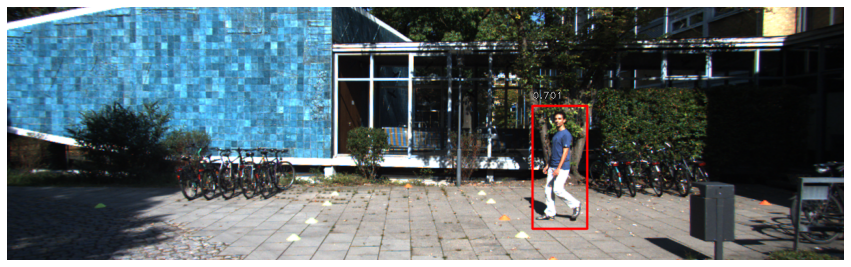

In [25]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

## 6-8. 프로젝트: 자율주행 보조 시스템 만들기

### 1. 자율주행 시스템 만들기

In [30]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
  
    
    # display images
#     if  visualize:
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        print(box)
          #box size
        width = box[2] - box[0]
        height = box[3] - box[1]

        
        if score <0.5:
             return "go" # 사람 물체 다아닐시

       
        elif label==1:   # 사람감지시 정지
            return "stop"
        
        else:          #자동차이면서 가로세로중 하나가 300이상이면 정지
            if width > 300 or height > 300:
                return"stop"
            
    
        b = box.astype(int)
        draw_box(draw, b, color=color_map[label])

        caption = "{:.3f}".format(score)
        draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()      
        
print(self_drive_assist(img_path))    

[768.4981  145.03459 848.07166 324.66406]
stop


### 자율주행 시스템 평가하기

[768.4981  145.03459 848.07166 324.66406]
[413.78653 166.04979 500.08817 338.9224 ]
[  0.      201.97931 306.2464  369.12827]
[ 732.65234    56.152252 1126.3885    373.6249  ]
[ 876.9417   174.73587 1238.5538   370.8041 ]
[592.40045 175.88464 626.2823  206.27983]


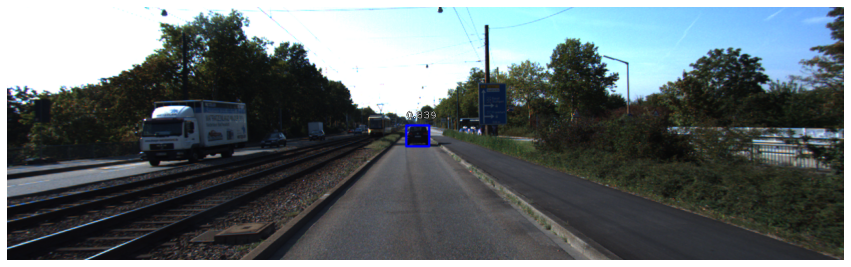

[196.90028 132.8914  356.15756 226.35294]
[627.68243 175.08145 665.5651  212.26578]


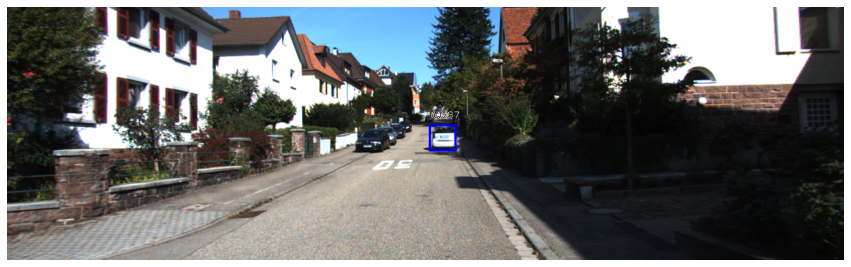

[517.77985 178.34482 564.86005 213.50764]
[810.0847  150.33652 890.1093  178.72005]
[695.3232  166.74576 794.4391  254.70564]
[ 21.964607 188.33655  212.39041  303.69907 ]
0점입니다.


In [31]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

### 사람과 자동차의 BB size를 잘 설정했다. retinanet에서 그렇게 만든듯싶다.  결과물에는 score가 0 이 나왔다. 사람이냐 자동차냐를 구분했는데, 사람을 인식하면 무조건 정지보다는 사람의 움직임 방향을 예측해서 자자동차의 속도를 조절해주는 방법이 필요하겠다. 정지물체 이동물체냐를 구분하는 방법을 first로 해서 자동차의 운행에 큰 지장이 없으면서도 주위의 상태를 잘 인식 context recognition하는 기술.